## **Applied Econometrics**

### **Assignment 4: Income and Savings from the PSID**

#### *Conor Bayliss*

##### **Data cleaning**

In this assignment, we'll start working with data from the PSID. 

To begin with, let's load the data and pull out the variables we are interested in using. These are:
* person identifiers, `person`
* year, `year`
* total income, `y`
* savings, `tot_assets1`, and `asset`
* age, `age`
Let's load in the data following Jo's code.

In [2]:
using CSV, DataFrames, DataFramesMeta, Statistics
data = @chain begin
    CSV.read("C:\\Users\\bayle\\Documents\\Github\\metrics\\hw4\\abb_aea_data.csv", DataFrame, missingstring="NA")
    @select :person :y :tot_assets1 :asset :age :year
end

Row,person,y,tot_assets1,asset,age,year
,Int64,Int64,Int64,Float64,Int64,Int64
1,12061,173100,605000,15500.0,65,98
2,17118,54000,60000,0.0,49,98
3,12630,61283,224000,39283.0,59,98
4,12647,42300,28240,0.0,38,98
5,5239,82275,7500,0.0,56,98
6,2671,69501,48000,3600.0,35,98
7,13027,68000,148000,20000.0,49,98
8,6791,93758,80000,160.0,41,98
9,6475,26581,23300,0.0,35,98


We are going to estimate the parameters of the income process in the simple savings model by matching the implied variances and covariances from the model to those calculated from the data. 
Recall that the income process is:
$$
\log(y_{it}) = \mu_t + \varepsilon_{it}
$$
where $\varepsilon_{it}$ is an AR1 process with autocorrelation $\rho$ and variance $\frac{\sigma^2_{\eta}}{(1-\rho^2)}$. Thus, there are only two parameters dictating the income process: $(\rho, \sigma^2_{\eta})$.

Let us now further clean the data. To map to the model, assume that agents begin (t=1) when aged 25 and live for 40 years (so the "terminal" period is at age 64). Thus, we should filter the data to look at only these ages.

In [3]:
@subset!(data, :age.>=25, :age.<=64)

Row,person,y,tot_assets1,asset,age,year
,Int64,Int64,Int64,Float64,Int64,Int64
1,17118,54000,60000,0.0,49,98
2,12630,61283,224000,39283.0,59,98
3,12647,42300,28240,0.0,38,98
4,5239,82275,7500,0.0,56,98
5,2671,69501,48000,3600.0,35,98
6,13027,68000,148000,20000.0,49,98
7,6791,93758,80000,160.0,41,98
8,6475,26581,23300,0.0,35,98
9,18332,33785,0,0.0,42,98


##### **Solving the Dynamic Programme**

Before we start the homework questions, let us run the provided code which solves the agents dynamic programme given a set of parameters. A brief review of the environment is also in order.

##### *Environment*

Time is discrete and indexed by $t$. Individuals live for a finite number of periods, $T$. They derive utility from consumption according to a CRRA utility function:
$$
u(c) = \frac{c^{1-\sigma}}{1-\sigma}
$$
and from "bequests", which are modelled here as cash on hand net of consumption in the final period:
$$
\nu(a) = \psi\frac{a^{1-\sigma}}{1-\sigma}.
$$
Consumption can be transferred 
between periods via a portfolio of one-period bonds ("savings", $a$) that can be purchased at the price $\frac{1}{1+r}$, and there is no borrowing. Individuals receive income $y$ every period that is governed by a deterministic component $\mu_t$ and a stochastic component $\varepsilon_{it}$:
$$
\log(y_t) = \mu_t + \varepsilon_{it}
$$
where $\varepsilon_{it}$ is a stationary AR1 process:
$$
\varepsilon_{it} = \rho\varepsilon_{it}+\eta_{it}
$$
where $\eta_{it} \sim \mathcal{N}(0,\sigma^2_{\eta})$. The unconditional variance of $\varepsilon_{it}$ is therefore $\frac{\sigma^2_{\eta}}{1-\rho^2}$.

Define 
$$
V_T(a,\varepsilon) = \max_c \{u(c)+ \nu(y-c) \}
$$
and define the remaining value functions recursively
$$
V_t(a,\varepsilon) = \max_{c,a'} \{u(c) + \beta \mathbb{E}_{y'|y}V_{t+1}(a',\varepsilon')\}
$$
$$
s.t. \quad c+\frac{1}{1+r}a' \leq a+y
$$
$$
a'\geq 0
$$

We're going to write code to solve the model using this recursive formulation.

Let's begin with setting up a default set of parameters.

In [16]:
pars = (; T = 45, # length of a lifetime
            β = 0.95, # discount factor
            σ = 2.0, # risk aversion
            ρ = 0.9, # persistence of income
            ση = 0.1, # standard deviation of income shocks
            μ = fill(2., 45), # mean of log income (array of size 45 filled with 2.0)
            ψ = 5., # scaling factor in utility from bequest
            r = 0.05 # interest rate
)

(T = 45, β = 0.95, σ = 2.0, ρ = 0.9, ση = 0.1, μ = [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], ψ = 5.0, r = 0.05)

Next, let us use Tauchen's method to approximate the income process as a discrete Markov process.

In [45]:
using Distributions, Random, LinearAlgebra
Φ(x) = cdf(Normal(), x)

function tauchen(ρ,ση,Kϵ)
    sd = ση/sqrt(1-ρ^2)
    grid = range(-3sd,stop=3sd,length=Kϵ)
    Π = zeros(Kϵ,Kϵ)
    Δ = grid[2]-grid[1]
    for j = 1:Kϵ
        Π[1,j] = Φ((grid[1]+Δ/2-ρ*grid[j])/ση)
        Π[end,j] = 1-Φ((grid[end]-Δ/2-ρ*grid[j])/ση)
        for k = 2:(Kϵ-1)
            Π[k,j] = Φ((grid[k]+Δ/2-ρ*grid[j])/ση) - Φ((grid[k]-Δ/2-ρ*grid[j])/ση)
        end
    end
    return Π, grid
end 

tauchen (generic function with 1 method)

The above code discretised the stochastic component of the income process. We also need to discretise the asset grid and define a max operator.

In [46]:
Ka = 100
Kϵ = 5
agrid = LinRange(0, pars.μ[1]*pars.T, Ka)   # asset grid LinRange(start, stop, length)
Π, ϵgrid = tauchen(pars.ρ, pars.ση, Kϵ) # transition matrix and grid for epsilon
pars = (; pars..., Ka = Ka, agrid = agrid, Π = Π, ϵgrid = ϵgrid, Kϵ = Kϵ) # merge the two dictionaries

u(c,σ) = c^(1-σ)/(1-σ)

function solve_max(V,t,iϵ,ia,pars)
    (;agrid,ϵgrid,Π,σ,Ka,r,β) = pars
    cash = exp(pars.μ[t] + ϵgrid[iϵ]) + agrid[ia] # cash on hand in period t with state (iϵ,ia) (which is an input of the function)
    amax = 0
    vmax = -Inf
    a = 1
    loop = true
    while loop && a<Ka
        c = cash - agrid[a]/(1+r) # consumption in period t with state (iϵ,ia) and action a
        if c>0
            v = u(c,σ) # utility from consumption
            for iϵp in axes(V,1) # loop over possible values of iϵ in period t+1
                v += β*Π[iϵp,iϵ]*V[iϵp,a,t+1] # add continuation value to utility for each possible value of iϵ in period t+1
            end
            if v>vmax # if the utility is higher than the maximum utility found so far
                vmax = v # update the maximum utility
                amax = a # update the asset choice that corresponds to the maximum utility
            end
        else
            loop = false
        end
        a += 1
    end
    return amax, vmax
end

solve_max (generic function with 1 method)

Next, a function that uses this max operator to get the value function for all states in a period, $t$, and records the optimal saving policy.

In [50]:
function iterate!(V,A,t,pars)
    for ia in axes(V,2), iϵ in axes(V,1)
        A[iϵ,ia,t], V[iϵ,ia,t] = solve_max(V,t,iϵ,ia,pars) # solve the maximization problem for each state (iϵ,ia) in period t
    end
end

function terminal_values!(V,pars)
    (;σ,ψ,agrid,T) = pars
    for ia in axes(V,2), iϵ in axes(V,1)
        # V[iϵ,ia] = ψ * u(agrid[ia],σ)
        V[iϵ,ia,T+1] = ψ * u(agrid[ia],σ) # alternative to the above (but make sure to change the backward_induction! function accordingly)
    end
end

terminal_values! (generic function with 1 method)

In [51]:
function backward_induction!(V,A,pars)
    (;ψ,σ,T,agrid) = pars
    # @views terminal_values!(V[:,:,T+1],pars)
    @views terminal_values!(V,pars) # alternative to the above (but make sure to change the terminal_values! function accordingly)
    for t in reverse(1:T)
        iterate!(V,A,t,pars)
    end
end

backward_induction! (generic function with 1 method)

Let's check the model solution and time it also.

In [53]:
V = zeros(pars.Kϵ,pars.Ka,pars.T+1)
A = zeros(Int64,pars.Kϵ,pars.Ka,pars.T)
backward_induction!(V,A,pars)
@time backward_induction!(V,A,pars)

  0.021388 seconds


Finally, let's plot the policy functions. The plot below shows savings policy at the median wage shock over time at different levels of assets.

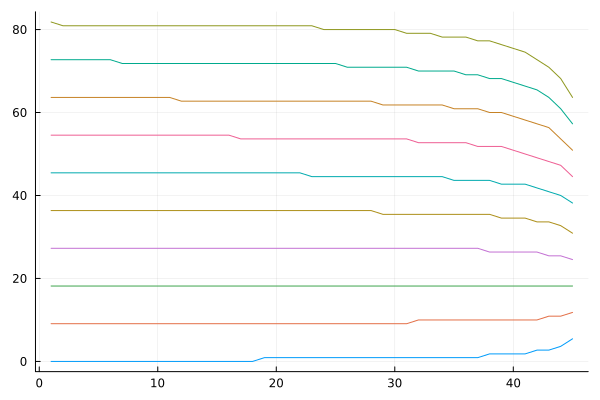

In [59]:
using Plots

plot(1:pars.T,agrid[A[3,1:10:Ka,:]'],legend=false) # plot the asset policy function every 10 gridpoints for the median wage shock (iϵ=3) over time

#### **Question 1**

*Estimate the parameters $\mu$ of using the sample mean of log income at each age. Create residuals $\hat{\varepsilon}_{it}$ for each individual in each period using these estimates.*

The functions below calculate the mean of log income for each age group, and then calculate the residual for each observation.

In [9]:
df = @chain data begin
    groupby(:age) # group by age  
    transform(:y => (y -> log.(y)) => :log_y) # take the log of y
    groupby(:age)
    combine(:log_y => mean => :log_y_mean) # calculate the mean of y for each group
end

df2 = @chain data begin
    groupby(:age) # group by age  
    transform(:y => (y -> log.(y)) => :log_y) # take the log of y
    groupby(:age)
    transform(:log_y => mean => :log_y_mean) # calculate the mean of y for each group
    groupby(:age)
    transform([:log_y, :log_y_mean] => ByRow(-) => :resid) # calculate the residuals
end

Row,person,y,tot_assets1,asset,age,year,log_y,log_y_mean,resid
,Int64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Float64
1,17118,54000,60000,0.0,49,98,10.8967,11.263,-0.366298
2,12630,61283,224000,39283.0,59,98,11.0233,11.2126,-0.189376
3,12647,42300,28240,0.0,38,98,10.6525,11.0695,-0.416965
4,5239,82275,7500,0.0,56,98,11.3178,11.219,0.0988382
5,2671,69501,48000,3600.0,35,98,11.1491,11.1646,-0.0155507
6,13027,68000,148000,20000.0,49,98,11.1273,11.263,-0.135774
7,6791,93758,80000,160.0,41,98,11.4485,11.1947,0.253742
8,6475,26581,23300,0.0,35,98,10.188,11.1646,-0.976695
9,18332,33785,0,0.0,42,98,10.4278,11.1441,-0.716335


#### **Question 2**

*The PSID data are taken biennially (every two years). Thus, write a function that takes a guess of $(\rho, \sigma{\eta})$ and calculates:*
1. *The unconditional variance of the residual.*
2. *The covariance of the residual with its two year lag.*
3. *The covariance of the residual with its four year lag.*


In the function below, we take a guess for the parameters of the AR1 process $(\rho,\sigma\eta)$ and return the necessary moments.

In [1]:
function AR1_process(ρ,ση)
    var = ση^2/(1-ρ^2)
    cov_2 = ρ^2
    cov_4 = ρ^4
    return var, cov_2, cov_4
end

AR1_process (generic function with 1 method)

Test the above function to make sure that it works.

In [17]:
v,c2,c4 = AR1_process(pars.ρ,pars.ση)

(0.052631578947368446, 0.81, 0.6561)

#### **Question 3**

*Calculate the sample equivalents of these moments from the data, and write a function that calculates the sum of the squared differences between the data and those predicted by a particular choice of $(\rho,\sigma_{\eta})$.*
*The code below creates the lags for income, and provides an example of calulating covariances.*

The following code calcualtes the two- and four-year lags of the residual for each observation. I also calculate the lags for income for completeness.

In [13]:
dlag1 = @chain df2 begin
    @select :year :person :resid
    @transform :year = :year .+ 2
    @rename :resid_lag1 = :resid
end

dlag2 = @chain df2 begin
    @select :year :person :resid
    @transform :year = :year .+ 4
    @rename :resid_lag2 = :resid
end

ylag1 = @chain df2 begin
    @select :year :person :log_y
    @transform :year = :year .+ 2
    @rename :log_y_lag1 = :log_y
end

ylag2 = @chain df2 begin
    @select :year :person :log_y
    @transform :year = :year .+ 4
    @rename :log_y_lag2 = :log_y
end

data = @chain df2 begin
    innerjoin(dlag1, on = [:person, :year])
    innerjoin(dlag2, on = [:person, :year])
    innerjoin(ylag1, on = [:person, :year])
    innerjoin(ylag2, on = [:person, :year])
end

Row,person,y,tot_assets1,asset,age,year,log_y,log_y_mean,resid,resid_lag1,resid_lag2,log_y_lag1,log_y_lag2
,Int64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,17118,43799,-2000,0.0,53,102,10.6874,11.3051,-0.617731,-0.433143,-0.366298,10.8532,10.8967
2,12630,68554,1519000,29454.0,63,102,11.1354,10.9559,0.179507,0.504693,-0.189376,11.5531,11.0233
3,12647,35000,78000,0.0,42,102,10.4631,11.1441,-0.681004,-0.799324,-0.416965,10.3255,10.6525
4,5239,49948,29900,0.0,60,102,10.8187,11.1392,-0.320425,-0.254721,0.0988382,10.9029,11.3178
5,2671,77000,84000,0.0,39,102,11.2516,11.1318,0.119767,0.129348,-0.0155507,11.2252,11.1491
6,13027,91000,248000,25000.0,53,102,11.4186,11.3051,0.113518,-0.453109,-0.135774,10.8332,11.1273
7,6791,122296,118650,154.0,45,102,11.7142,11.2052,0.509001,0.321919,0.253742,11.5179,11.4485
8,18332,54000,56000,0.0,46,102,10.8967,11.2661,-0.369324,-0.622871,-0.716335,10.6016,10.4278
9,3856,95800,357000,9600.0,37,102,11.47,11.0959,0.374122,0.0790909,-0.163537,11.2437,10.9205


We now calculate the sample equivalent of the relevant moments from the data. The code below calculates the unconditional variance of the residuals, as well as the relevant covariances.

In [19]:
estimates = @chain data begin
    @combine begin
        :v_resid = var(:resid)
        :c_resid_1 = cov(:resid, :resid_lag1)
        :c_resid_2 = cov(:resid, :resid_lag2)
    end
end

data_estimates = estimates.v_resid, estimates.c_resid_1, estimates.c_resid_2

([0.6042229503656219], [0.39374914076225126], [0.3537264122186027])

We also need to write a function to calculate the sum of the squared differences between the sample moments and the moments predicted by our guess. 

In [35]:
function ssd(ρ,ση,d)
    var, cov_2, cov_4 = AR1_process(ρ,ση)
    var_data, cov_2_data, cov_4_data = d
    return [(var.-var_data).^2, (cov_2.-cov_2_data).^2, (cov_4.-cov_4_data).^2]
end

ssd (generic function with 1 method)

Let's test this function.

In [36]:
trial = ssd(pars.ρ,pars.ση,data_estimates)

3-element Vector{Vector{Float64}}:
 [0.3042530410230696]
 [0.17326477781616417]
 [0.0914297865877944]

#### **Question 4**

*Now estimate the income process parameters by minimising this weighted sum of squares (i.e. implement a minimum distance estimator with identity weighting matrix).*

Finally, let's minimise the weighted sum of squares, with the identity matrix as our weighting matrix.

In [39]:
function minimise(ρ,ση,d)
    weighted_ssd = ssd(ρ,ση,d)'*I*ssd(ρ,ση,d)
    return weighted_ssd
end

minimise (generic function with 1 method)

Test the function.

In [40]:
min_test = minimise(pars.ρ,pars.ση,data_estimates)

0.13095000207896004

Now, optimise.

In [44]:
using Optim

result = optimize(guess -> minimise(guess[1],guess[2],data_estimates), [pars.ρ,pars.ση], NelderMead())

solution = Optim.minimizer(result)

2-element Vector{Float64}:
 0.7062014705501509
 0.5511715773027391

As a check, run the following code:

In [45]:
out_ρ, out_ση = AR1_process(solution[1],solution[2])

(0.6060294066149724, 0.49872051700719566, 0.24872215408392456)

#### **Question 5**

*Note that in this model,*
$$
\rho = \frac{\mathbb{C}(\varepsilon_{it},\varepsilon_{it-1})}{\mathbb{V}(\varepsilon_{it})}.
$$
*Suppose that the true model is*
$$
\log(y_{it}) = \mu_t + \varepsilon_{it} + \zeta_{it}
$$
*where $\zeta_{it}$ is an additional shock to income that is completely iid (i.e. no persistence). Suppose we estimate the persistence parameter $\rho$ using the relationship above (which is now misspecified).*
$$
\hat{\rho} = \frac{\widehat{\mathbb{C}(\varepsilon_{it},\varepsilon_{it-1})}}{\widehat{\mathbb{V}(\varepsilon_{it})}}
$$
*Does the population limit of our estimator over- or under-estimate $\rho$, the persistence in $\varepsilon$?*

If the true model is 
$$
\log(y_{it}) = \mu_t + \varepsilon_{it} + \zeta_{it}, \quad \varepsilon_{it} = \rho \varepsilon_{it-1} + \eta_{it}, \quad \eta_{it} \sim \mathcal{N}(0,\sigma^2_{\eta}), \forall t
$$
but we estimate $\rho$ according to
$$
\log(y_{it}) = \mu_t + \varepsilon_{it}, \quad \varepsilon_{it} = \rho \varepsilon_{it-1} + \eta_{it}, \quad \eta_{it} \sim \mathcal{N}(0,\sigma^2_{\eta}), \forall t
$$
$$
\hat{\rho} = \frac{\widehat{\mathbb{C}(\varepsilon_{it},\varepsilon_{it-1})}}{\widehat{\mathbb{V}(\varepsilon_{it})}}
$$
then our estimator will **under-estimate** $\rho$, the persistence in $\varepsilon$. This is because the iid shock $\zeta_{it}$ introduces additional variance into $\log(y_{it})$, but our estimate assumes that all of the variation in $\log(y_{it})$ comes from the AR1 process. Hence, the denominator of our estimate will be larger than it should be, whilst the iid nature of $\zeta_{it}$ across time means that the numerator will be unaffected. Hence, our estimator $\hat{\rho}$ under-estimates $\rho$.